In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data preprocessing (same as before)
df = pd.read_csv("../treedata.csv")
df = df.drop(columns=["ObjectID", "Other.1", "Length of Failed Part", "Diameter of Failed Part"], axis=1)
df = df.fillna("None")

categorical_cols = [
    "Tree Species", "Condition", "Site Factors", "Type of Soil", "Weather factors",
    "Failed Part", "Root Failure", "Stem Failure", "Branch Failure",
    "Location and Percentage of Decay", "Decay Present"
]

from collections import defaultdict
all_unique_labels = defaultdict(set)

# extract all unique labels per column
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].apply(lambda x: [item.strip() for item in x.split(",") if item.strip() != ""])
    for items in df[col]:
        all_unique_labels[col].update(items)

for col in categorical_cols:
    for label in all_unique_labels[col]:
        df[f"{col}_{label}"] = df[col].apply(lambda x: int(label in x))

df = df.drop(columns=categorical_cols)

X = df.drop(columns=["Failed Part_BranchFailure", "Failed Part_RootFailure", "Failed Part_StemFailure", "Root Failure_None", "Stem Failure_None", "Branch Failure_None"])

Using device: cpu
Starting training pipeline for both model types...

Training root failure models...

--- Complex Model ---
Training tree_root_failure_complex (complex) with early stopping (patience=5)
Early stopping triggered at epoch 9
Best validation loss: 0.3495
Training completed after 9 epochs
Training stopped early due to lack of improvement

--- Simple Model ---
Training tree_root_failure_simple (simple) with early stopping (patience=5)
Epoch 10/100 | Train Loss: 0.3230 | Val Loss: 0.3849 | Train Acc: 89.49% | Val Acc: 86.09% | ES Counter: 0/5
Epoch 20/100 | Train Loss: 0.1840 | Val Loss: 0.3553 | Train Acc: 92.90% | Val Acc: 86.09% | ES Counter: 3/5
Early stopping triggered at epoch 22
Best validation loss: 0.3376
Training completed after 22 epochs
Training stopped early due to lack of improvement
Completed training for root failure models

Training stem failure models...

--- Complex Model ---
Training tree_stem_failure_complex (complex) with early stopping (patience=5)
Epoc

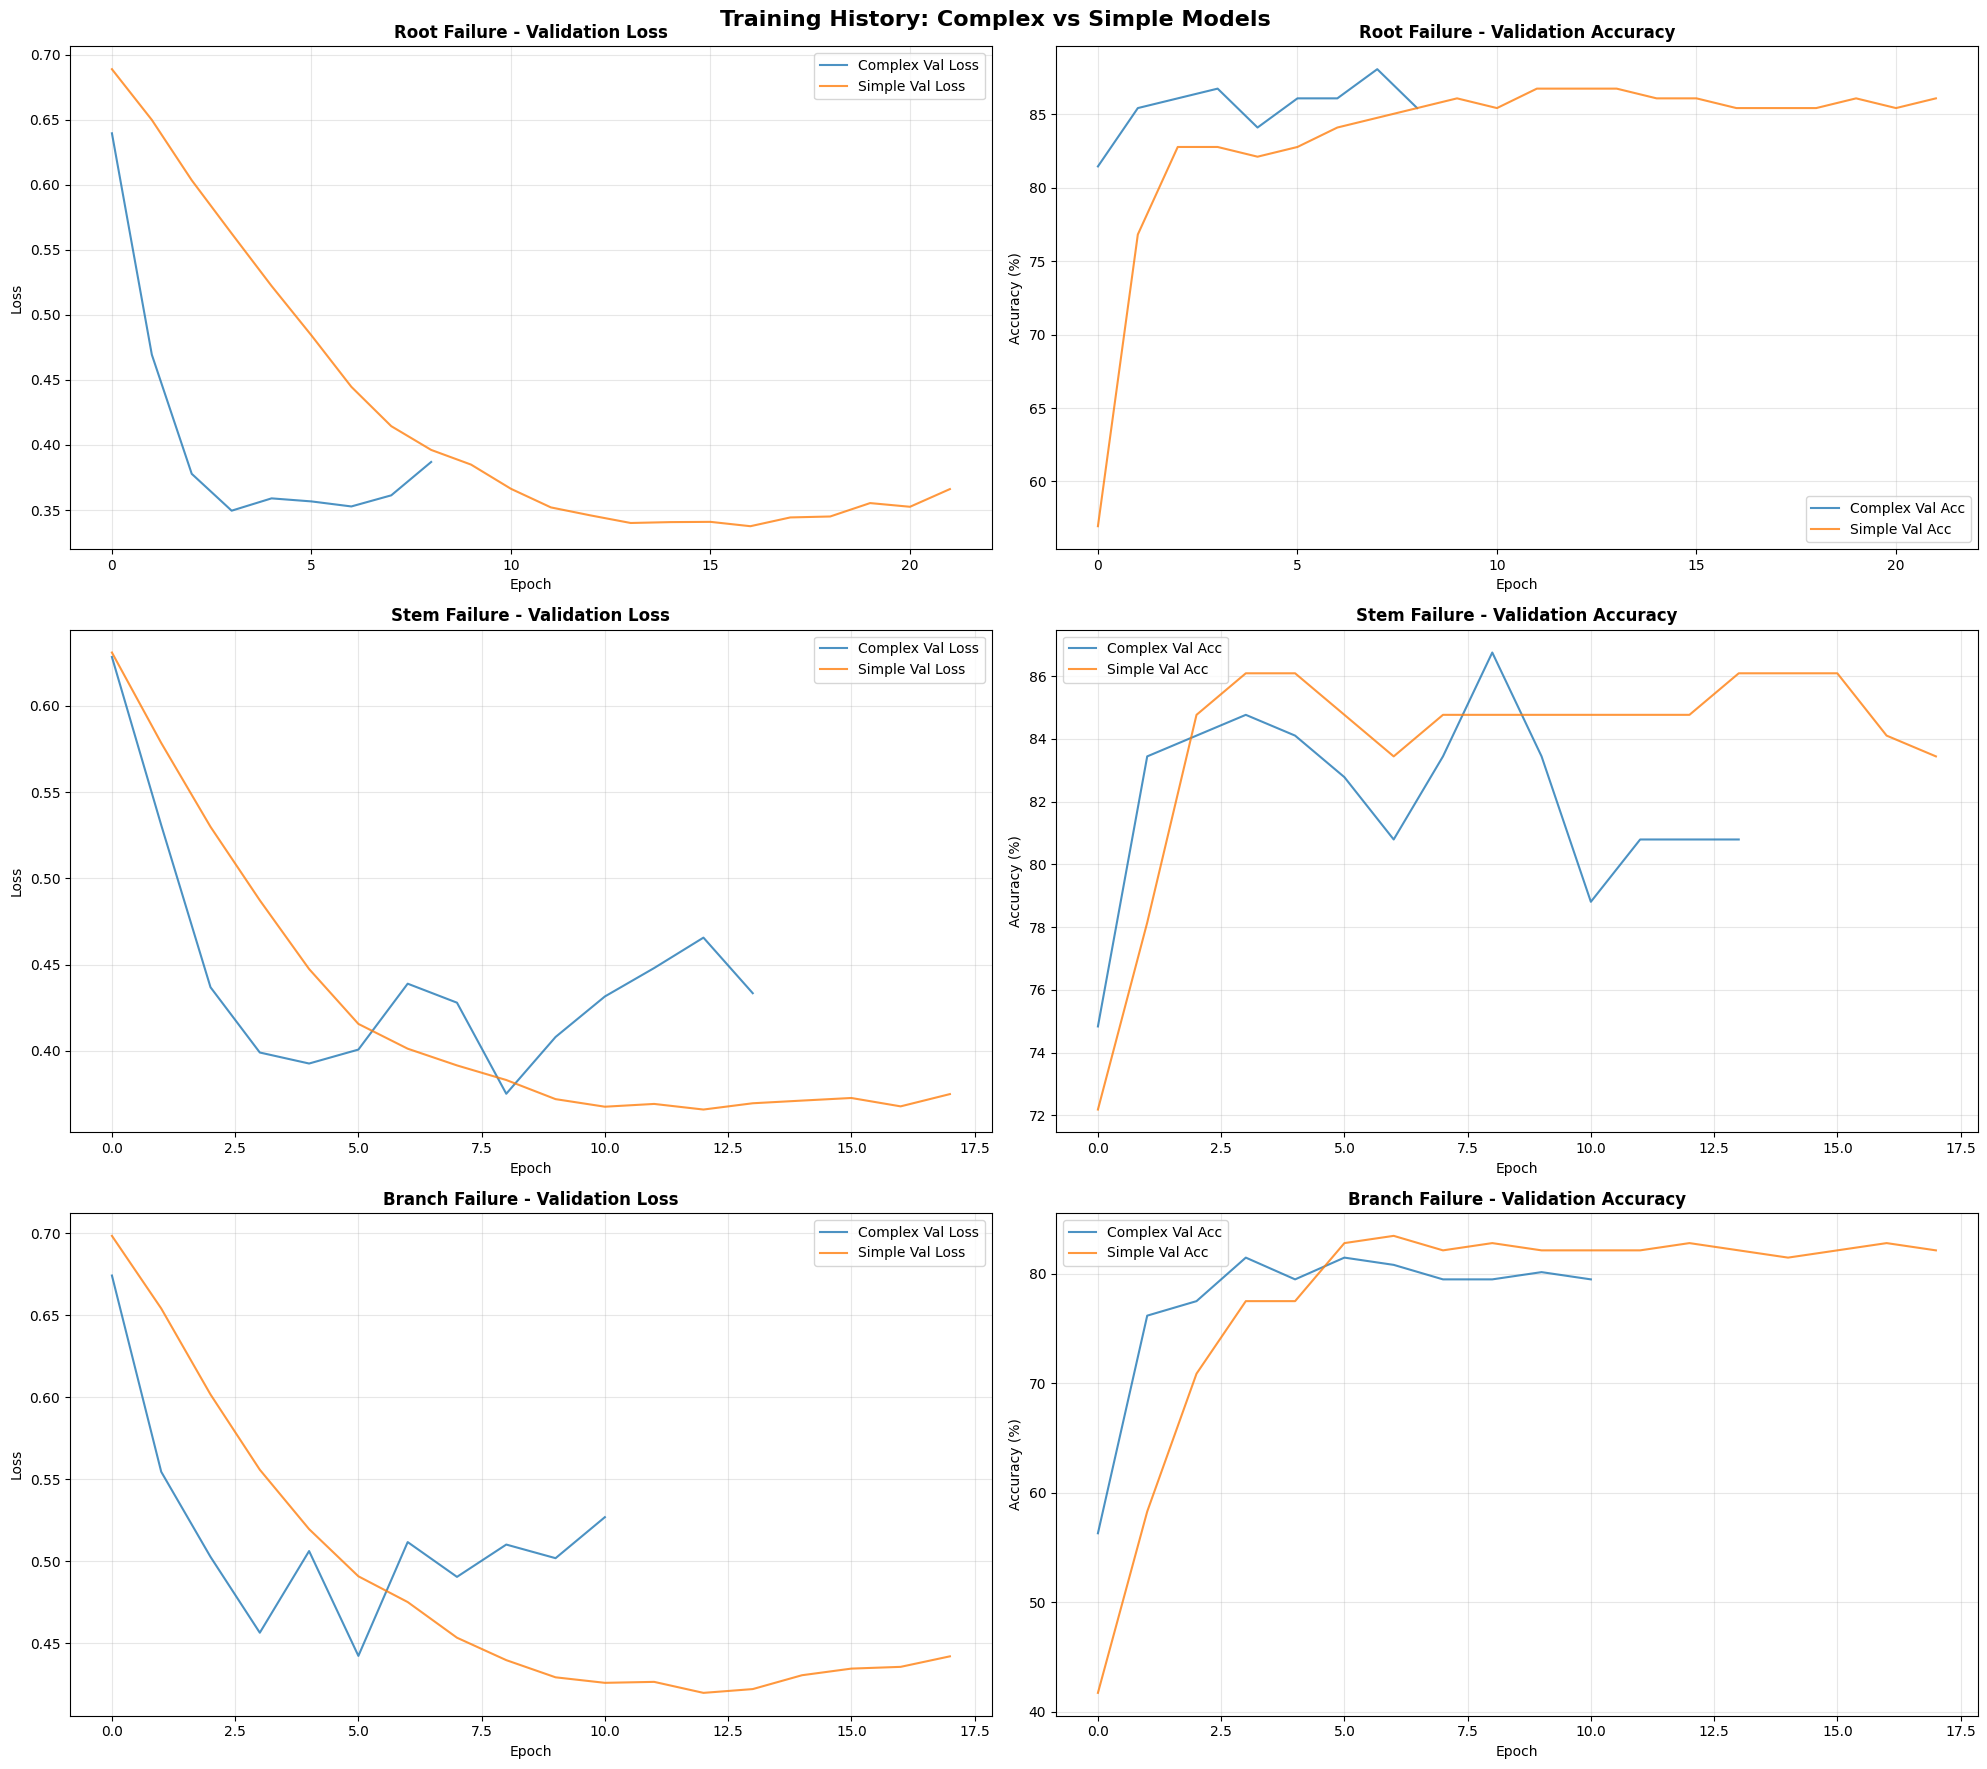

2. Plotting performance comparison...


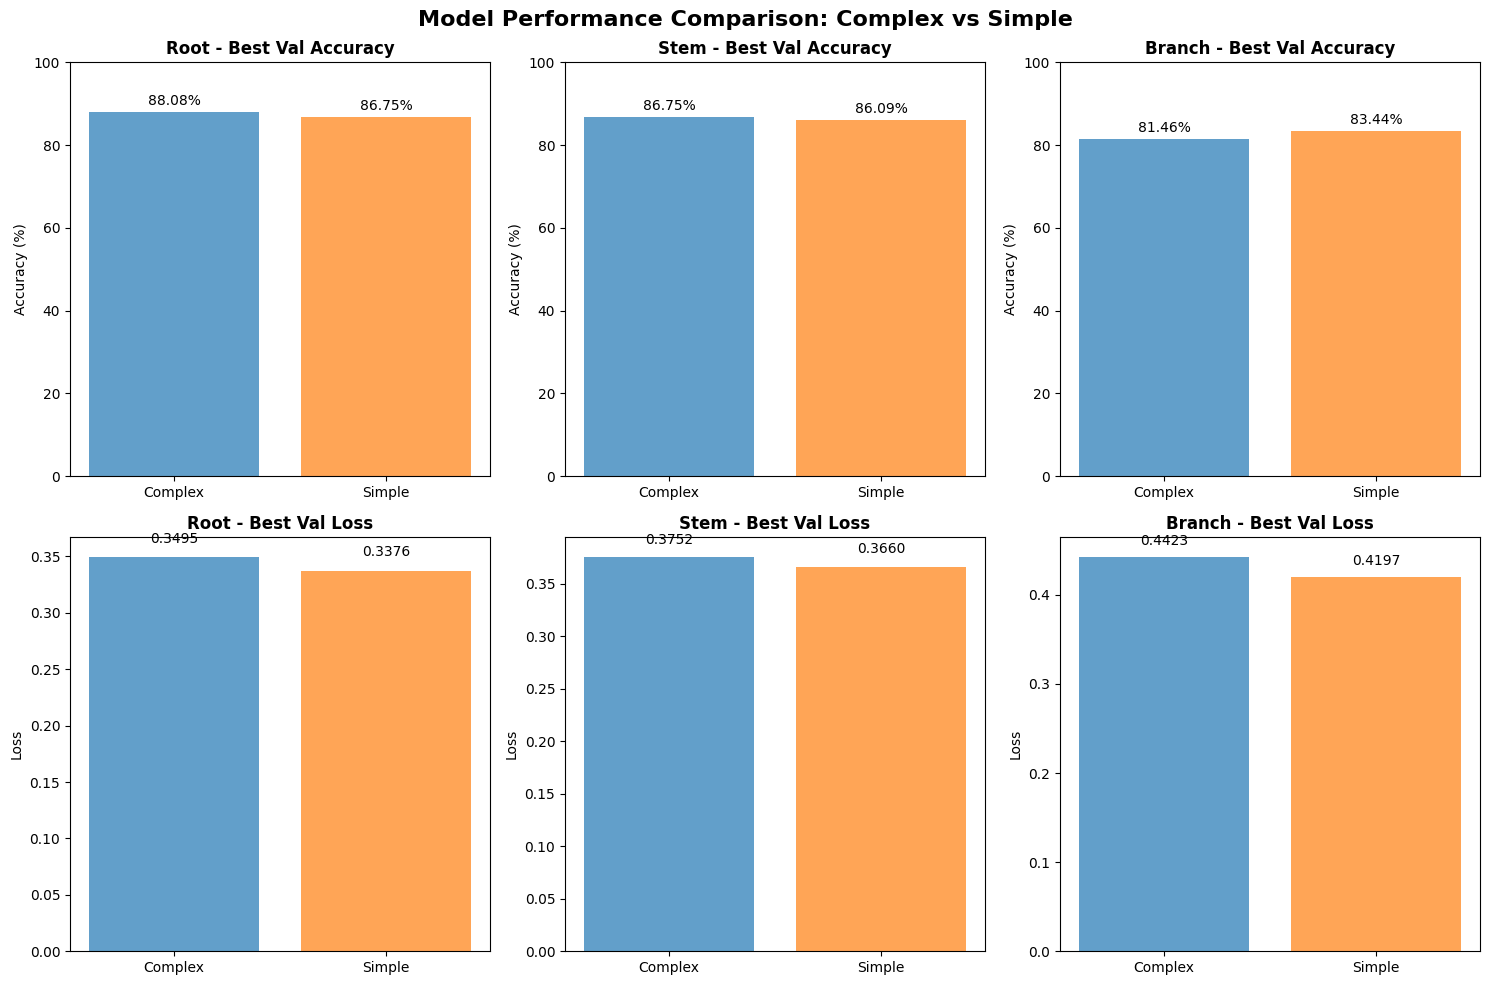

3. Generating interpretability analysis...
INTERPRETABILITY ANALYSIS REPORT

Analyzing ROOT Failure Model
Computing SHAP values for root complex model...
Computing SHAP values for root simple model...


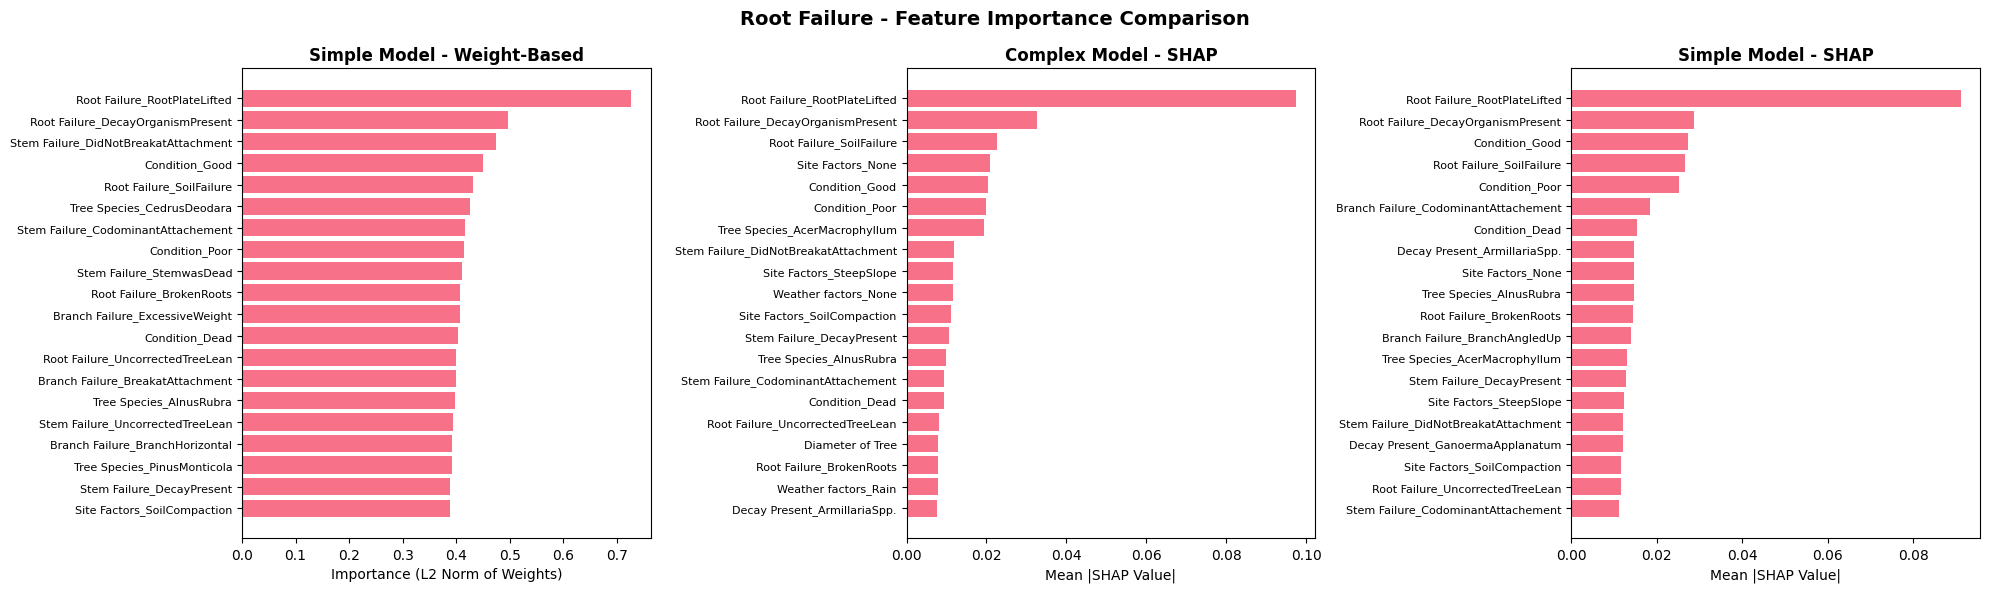


--- SHAP Summary for Complex Model ---
Generating SHAP summary plot for root complex model...


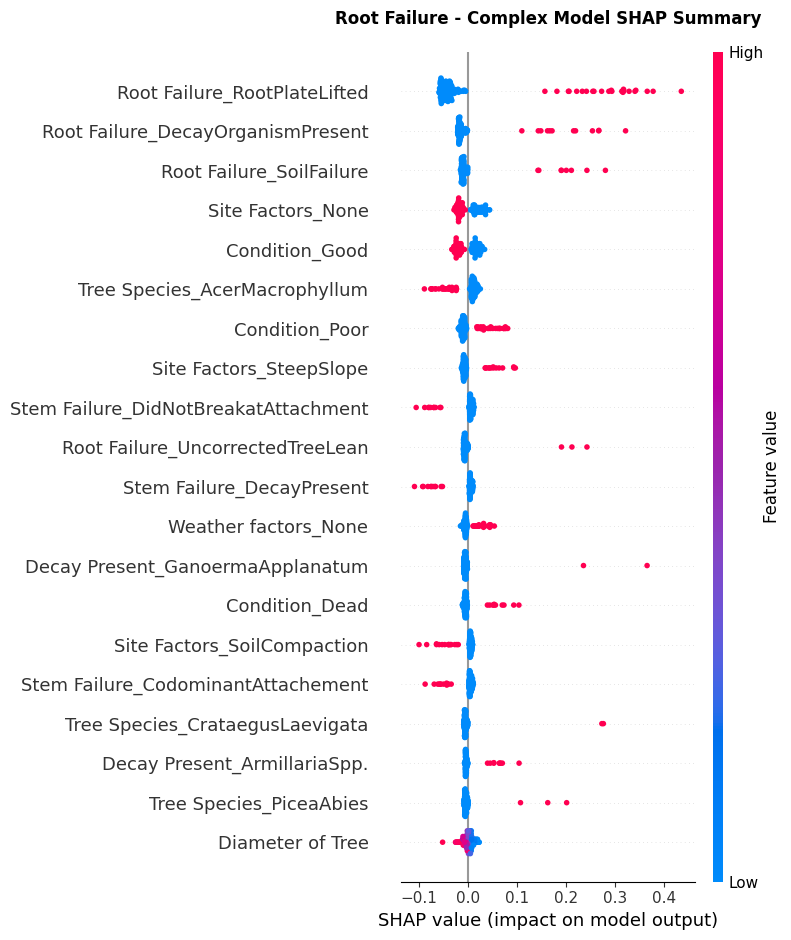


--- SHAP Summary for Simple Model ---
Generating SHAP summary plot for root simple model...


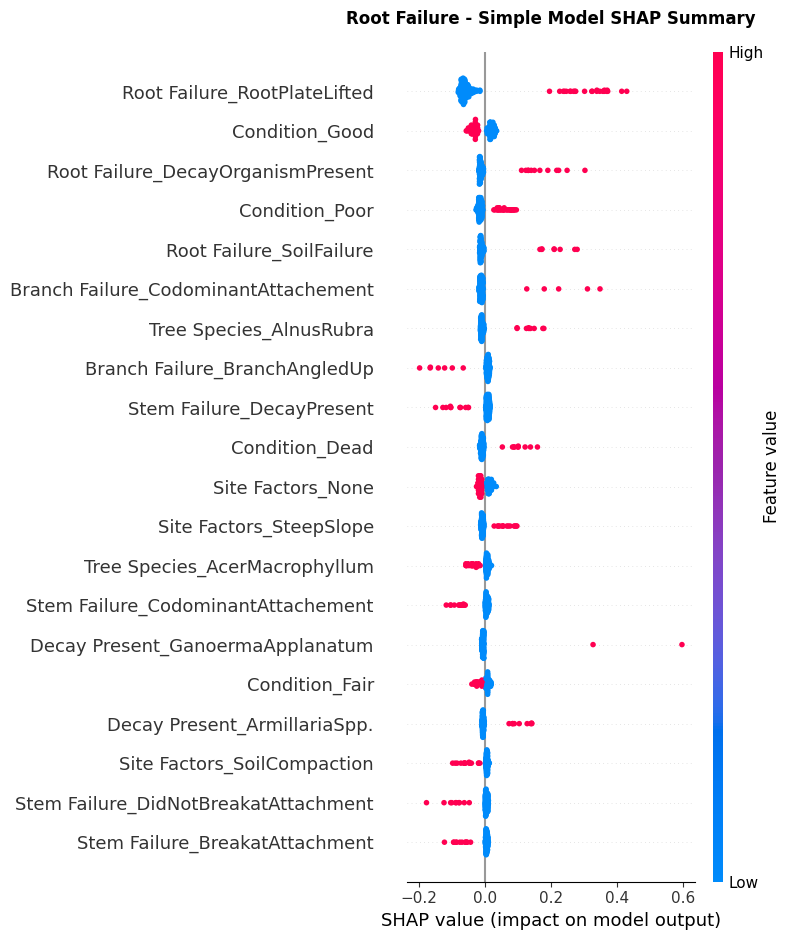


--- Top 10 Features by Method ---

Simple Model (Weights):
                             feature  importance
        Root Failure_RootPlateLifted    0.727214
   Root Failure_DecayOrganismPresent    0.497581
Stem Failure_DidNotBreakatAttachment    0.474777
                      Condition_Good    0.450864
            Root Failure_SoilFailure    0.431642
          Tree Species_CedrusDeodara    0.425747
  Stem Failure_CodominantAttachement    0.415732
                      Condition_Poor    0.413710
            Stem Failure_StemwasDead    0.411359
            Root Failure_BrokenRoots    0.406605

Complex Model (SHAP):
                             feature  importance
        Root Failure_RootPlateLifted    0.097429
   Root Failure_DecayOrganismPresent    0.032613
            Root Failure_SoilFailure    0.022721
                   Site Factors_None    0.020788
                      Condition_Good    0.020493
                      Condition_Poor    0.019850
       Tree Species_AcerMacrophyllu

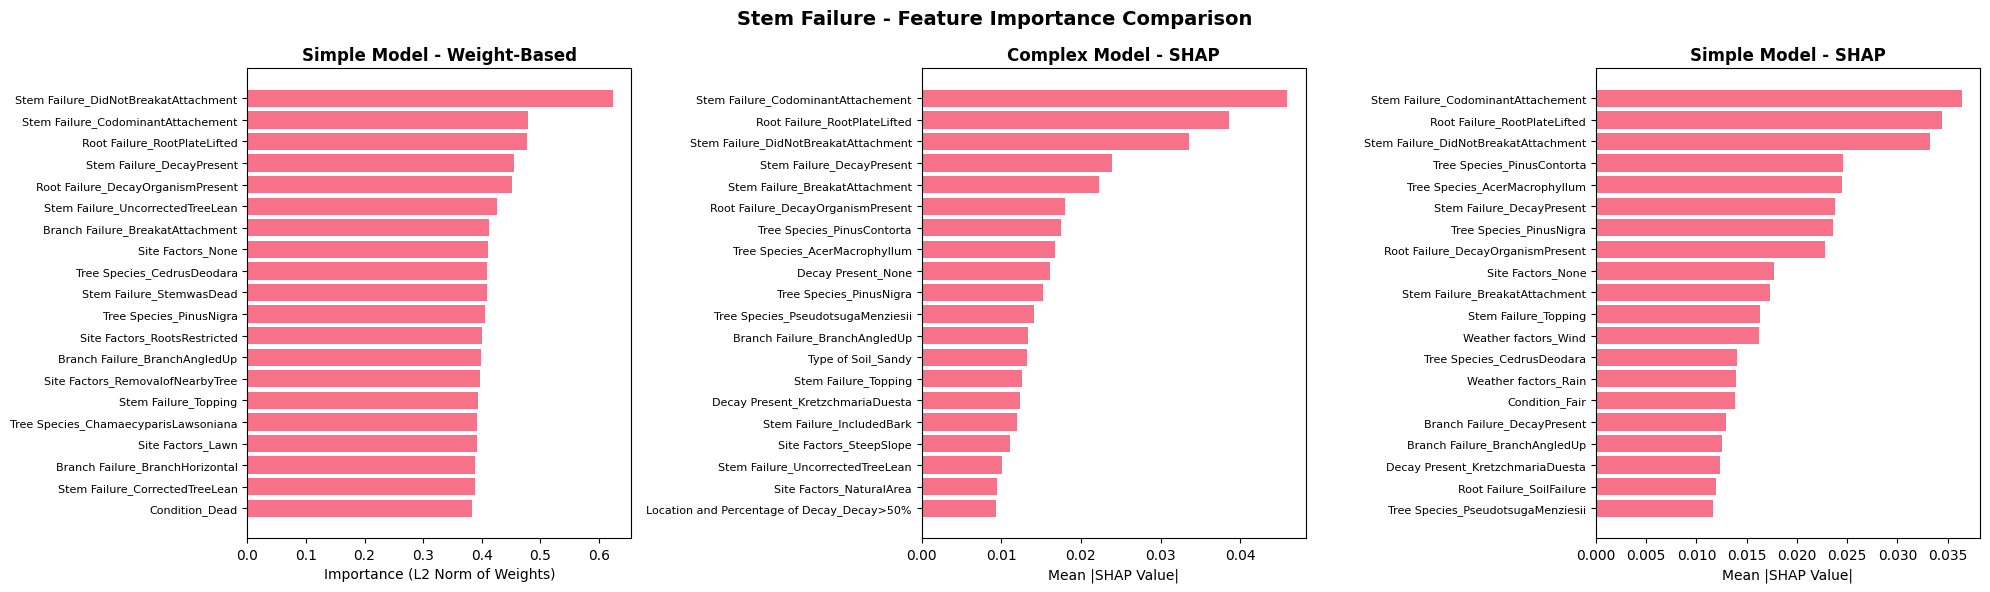


--- SHAP Summary for Complex Model ---
Generating SHAP summary plot for stem complex model...


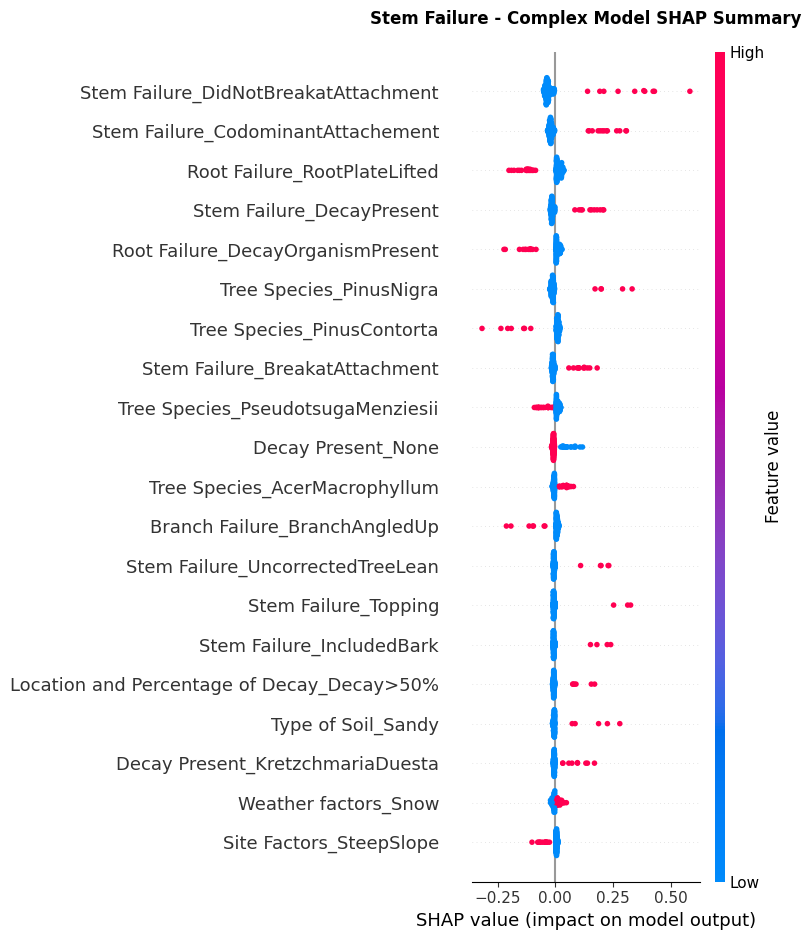


--- SHAP Summary for Simple Model ---
Generating SHAP summary plot for stem simple model...


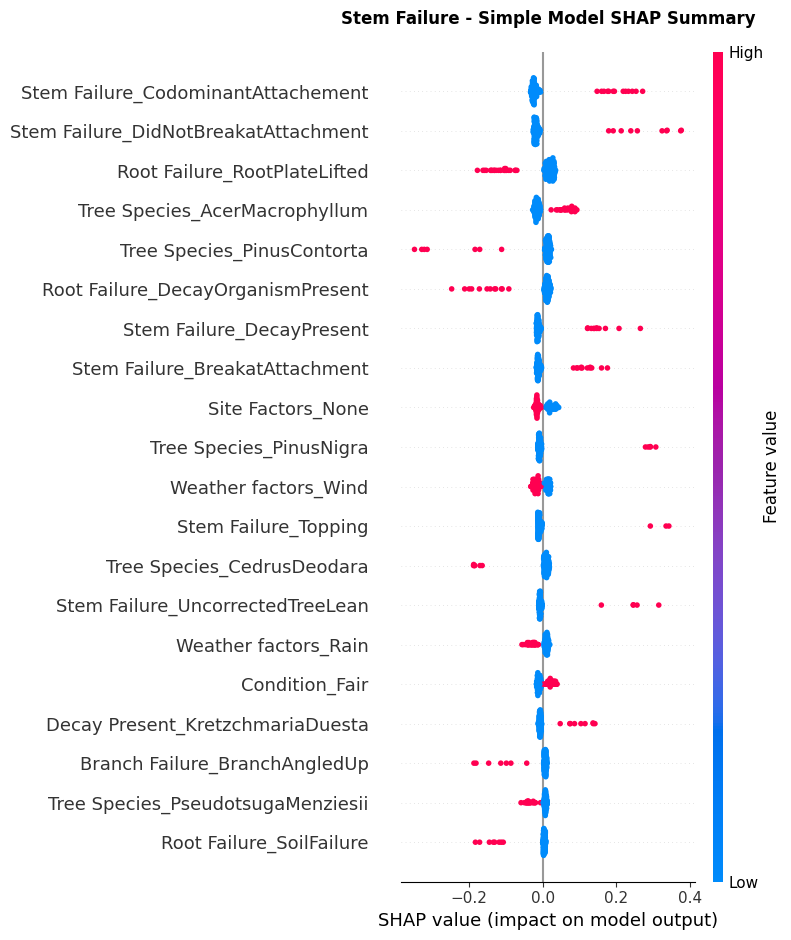


--- Top 10 Features by Method ---

Simple Model (Weights):
                             feature  importance
Stem Failure_DidNotBreakatAttachment    0.624447
  Stem Failure_CodominantAttachement    0.478546
        Root Failure_RootPlateLifted    0.477274
           Stem Failure_DecayPresent    0.454607
   Root Failure_DecayOrganismPresent    0.452642
    Stem Failure_UncorrectedTreeLean    0.426753
    Branch Failure_BreakatAttachment    0.412770
                   Site Factors_None    0.410007
          Tree Species_CedrusDeodara    0.409401
            Stem Failure_StemwasDead    0.408902

Complex Model (SHAP):
                             feature  importance
  Stem Failure_CodominantAttachement    0.045932
        Root Failure_RootPlateLifted    0.038652
Stem Failure_DidNotBreakatAttachment    0.033609
           Stem Failure_DecayPresent    0.023887
      Stem Failure_BreakatAttachment    0.022276
   Root Failure_DecayOrganismPresent    0.017988
          Tree Species_PinusContort

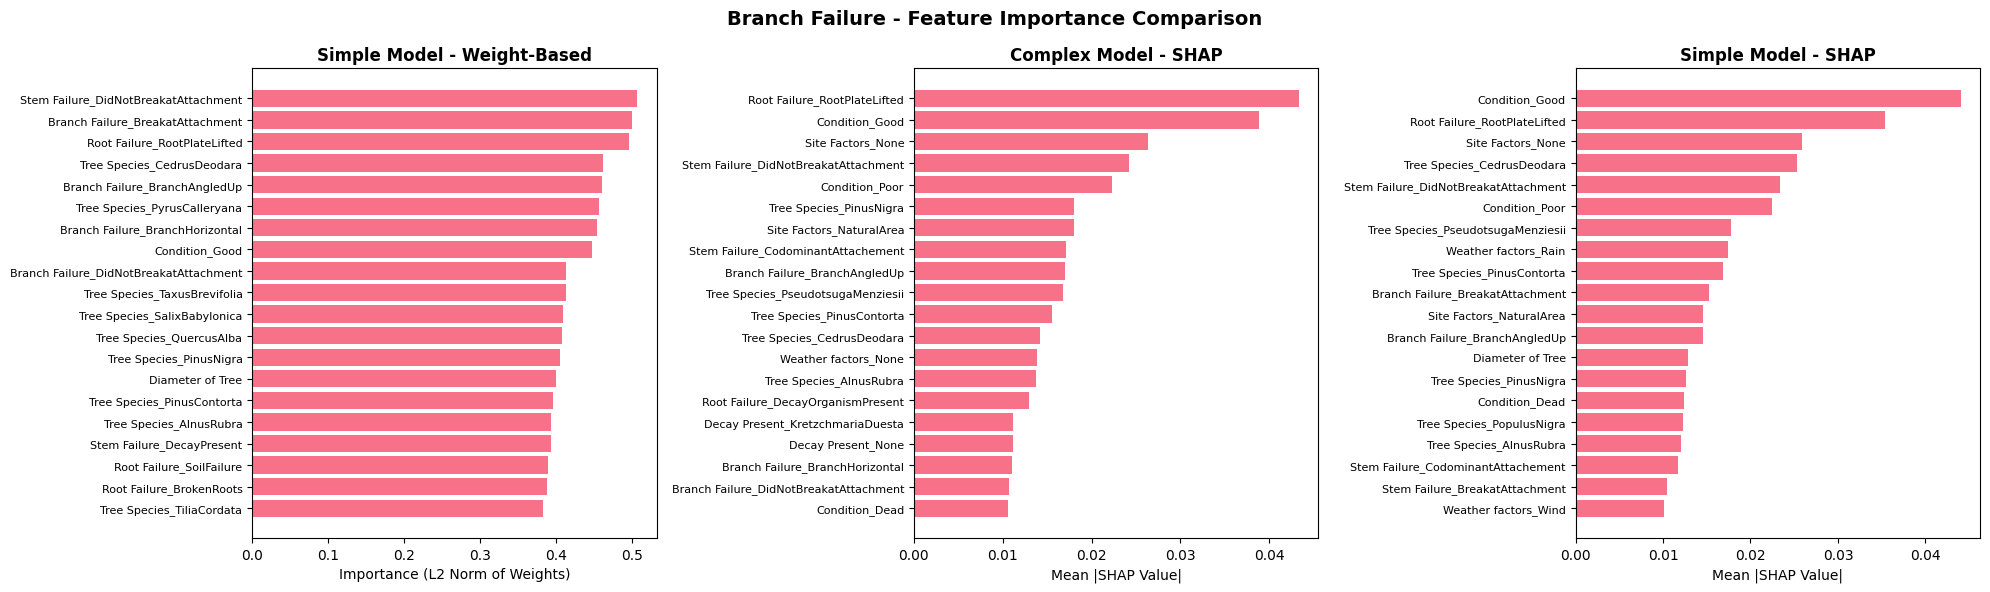


--- SHAP Summary for Complex Model ---
Generating SHAP summary plot for branch complex model...


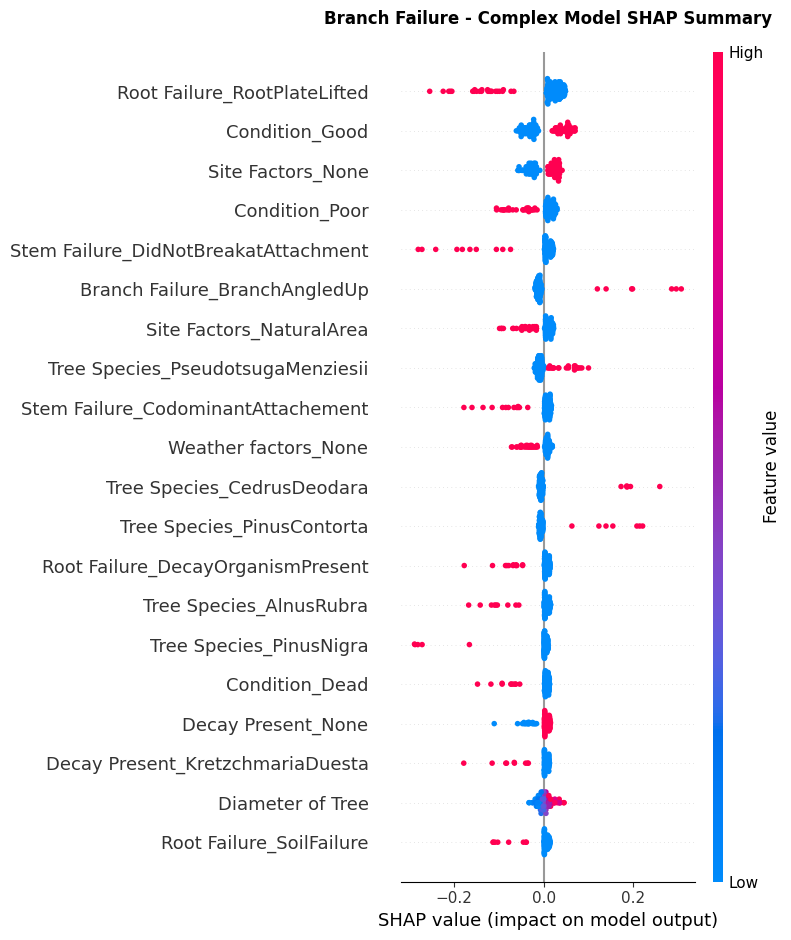


--- SHAP Summary for Simple Model ---
Generating SHAP summary plot for branch simple model...


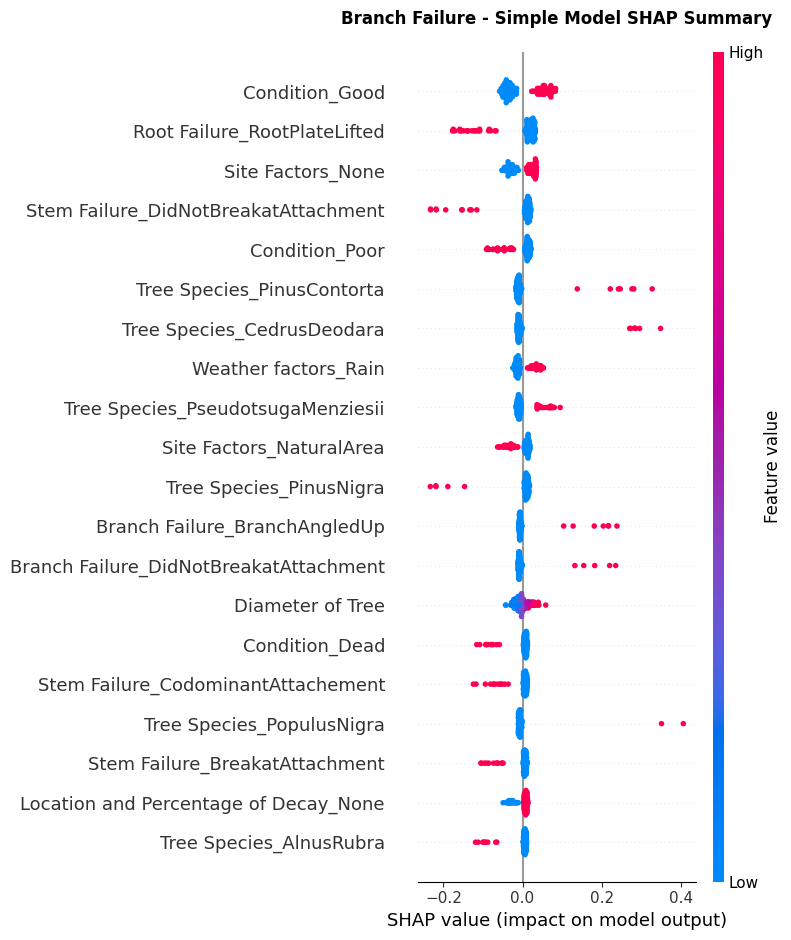


--- Top 10 Features by Method ---

Simple Model (Weights):
                               feature  importance
  Stem Failure_DidNotBreakatAttachment    0.507396
      Branch Failure_BreakatAttachment    0.499911
          Root Failure_RootPlateLifted    0.496199
            Tree Species_CedrusDeodara    0.461906
         Branch Failure_BranchAngledUp    0.460123
          Tree Species_PyrusCalleryana    0.456861
       Branch Failure_BranchHorizontal    0.454452
                        Condition_Good    0.447168
Branch Failure_DidNotBreakatAttachment    0.413675
          Tree Species_TaxusBrevifolia    0.412820

Complex Model (SHAP):
                             feature  importance
        Root Failure_RootPlateLifted    0.043365
                      Condition_Good    0.038886
                   Site Factors_None    0.026384
Stem Failure_DidNotBreakatAttachment    0.024231
                      Condition_Poor    0.022350
             Tree Species_PinusNigra    0.018009
            S

In [5]:
# %%
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data preprocessing
df = pd.read_csv("../treedata.csv")
df = df.drop(columns=["ObjectID", "Other.1", "Length of Failed Part", "Diameter of Failed Part"], axis=1)
df = df.fillna("None")

categorical_cols = [
    "Tree Species", "Condition", "Site Factors", "Type of Soil", "Weather factors",
    "Failed Part", "Root Failure", "Stem Failure", "Branch Failure",
    "Location and Percentage of Decay", "Decay Present"
]

from collections import defaultdict
all_unique_labels = defaultdict(set)

# extract all unique labels per column
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].apply(lambda x: [item.strip() for item in x.split(",") if item.strip() != ""])
    for items in df[col]:
        all_unique_labels[col].update(items)

for col in categorical_cols:
    for label in all_unique_labels[col]:
        df[f"{col}_{label}"] = df[col].apply(lambda x: int(label in x))

df = df.drop(columns=categorical_cols)

X = df.drop(columns=["Failed Part_BranchFailure", "Failed Part_RootFailure", "Failed Part_StemFailure", "Root Failure_None", "Stem Failure_None", "Branch Failure_None"])

# Store feature names for later use
feature_names = X.columns.tolist()

# %%
os.makedirs('models', exist_ok=True)

# %%
class TreeFailureNet(nn.Module):
    """Complex deep network"""
    def __init__(self, input_size, hidden_sizes=[1024, 1024, 512, 128, 32], dropout_rate=0.4):
        super(TreeFailureNet, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class SimpleTreeFailureNet(nn.Module):
    """Simple shallow network for interpretability"""
    def __init__(self, input_size, hidden_sizes=[64, 32], dropout_rate=0.4):
        super(SimpleTreeFailureNet, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
    def get_feature_importance(self):
        """Extract feature importance from first layer weights"""
        first_layer = self.network[0]  # First Linear layer
        weights = first_layer.weight.data.cpu().numpy()
        # Use L2 norm of weights for each input feature
        importance = np.linalg.norm(weights, axis=0)
        return importance

class EarlyStopping:
    """Early stopping utility class"""
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        
        if mode == 'min':
            self.monitor_op = lambda current, best: current < (best - self.min_delta)
        else:
            self.monitor_op = lambda current, best: current > (best + self.min_delta)
    
    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif self.monitor_op(score, self.best_score):
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
        
        return self.early_stop
    
    def save_checkpoint(self, model):
        """Save model when validation score improves"""
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()

class TreeFailureTrainer:
    def __init__(self, input_size, model_name, model_type='complex', hidden_sizes=None, 
                 dropout_rate=0.4, learning_rate=0.001, batch_size=32, epochs=100, 
                 early_stopping_patience=15, early_stopping_min_delta=0.001, 
                 early_stopping_mode='min'):
        
        self.model_type = model_type
        
        if model_type == 'simple':
            self.model = SimpleTreeFailureNet(input_size, hidden_sizes or [64, 32], dropout_rate).to(device)
        else:
            self.model = TreeFailureNet(input_size, hidden_sizes or [1024, 1024, 512, 128, 32], dropout_rate).to(device)
        
        self.model_name = model_name
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=10, factor=0.5)
        self.batch_size = batch_size
        self.epochs = epochs
        self.scaler = StandardScaler()
        
        # Early stopping parameters
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience,
            min_delta=early_stopping_min_delta,
            restore_best_weights=True,
            mode=early_stopping_mode
        )
        
    def prepare_data(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train_scaled).to(device),
            torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
        )
        test_dataset = TensorDataset(
            torch.FloatTensor(X_test_scaled).to(device),
            torch.FloatTensor(y_test.values).unsqueeze(1).to(device)
        )
        
        return (
            DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True),
            DataLoader(test_dataset, batch_size=self.batch_size),
            X_test_scaled, y_test
        )
    
    def train(self, X, y):
        train_loader, test_loader, X_test_scaled, y_test = self.prepare_data(X, y)
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        best_loss = float('inf')
        epochs_run = 0
        
        print(f"Training {self.model_name} ({self.model_type}) with early stopping (patience={self.early_stopping.patience})")
        
        for epoch in range(self.epochs):
            epochs_run = epoch + 1
            
            # Training phase
            self.model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                
                epoch_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
            
            # Validation phase
            val_loss, val_acc = self.evaluate(test_loader)
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            
            # Save history
            history['train_loss'].append(epoch_loss/len(train_loader))
            history['val_loss'].append(val_loss)
            history['train_acc'].append(100*correct/total)
            history['val_acc'].append(val_acc)
            
            # Check for best model
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'scaler': self.scaler,
                    'history': history,
                    'epoch': epoch,
                    'best_val_loss': best_loss,
                    'X_test': X_test_scaled,
                    'y_test': y_test.values,
                    'model_type': self.model_type
                }, f'models/{self.model_name}_best.pth')
            
            # Early stopping check
            if self.early_stopping(val_loss, self.model):
                print(f'Early stopping triggered at epoch {epoch+1}')
                print(f'Best validation loss: {self.early_stopping.best_score:.4f}')
                break
            
            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{self.epochs} | '
                      f'Train Loss: {history["train_loss"][-1]:.4f} | '
                      f'Val Loss: {val_loss:.4f} | '
                      f'Train Acc: {history["train_acc"][-1]:.2f}% | '
                      f'Val Acc: {val_acc:.2f}% | '
                      f'ES Counter: {self.early_stopping.counter}/{self.early_stopping.patience}')
        
        print(f"Training completed after {epochs_run} epochs")
        if self.early_stopping.early_stop:
            print("Training stopped early due to lack of improvement")
        
        return history
    
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in loader:
                outputs = self.model(batch_X)
                total_loss += self.criterion(outputs, batch_y).item()
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        return total_loss/len(loader), 100*correct/total

def train_all_models(X, y_root, y_stem, y_branch, epochs=100, early_stopping_patience=15):
    """
    Train both complex and simple models for all tree failure types
    """
    models = {
        'root': y_root,
        'stem': y_stem,
        'branch': y_branch
    }
    
    training_results = {}
    
    for name, y in models.items():
        print(f"\n{'='*60}")
        print(f"Training {name} failure models...")
        print(f"{'='*60}")
        
        # Train complex model
        print(f"\n--- Complex Model ---")
        complex_trainer = TreeFailureTrainer(
            input_size=X.shape[1], 
            model_name=f"tree_{name}_failure_complex",
            model_type='complex',
            epochs=epochs,
            early_stopping_patience=early_stopping_patience,
            early_stopping_min_delta=0.001,
            early_stopping_mode='min'
        )
        complex_history = complex_trainer.train(X, y)
        
        # Train simple model
        print(f"\n--- Simple Model ---")
        simple_trainer = TreeFailureTrainer(
            input_size=X.shape[1], 
            model_name=f"tree_{name}_failure_simple",
            model_type='simple',
            hidden_sizes=[64, 32],
            epochs=epochs,
            early_stopping_patience=early_stopping_patience,
            early_stopping_min_delta=0.001,
            early_stopping_mode='min'
        )
        simple_history = simple_trainer.train(X, y)
        
        training_results[name] = {
            'complex': {
                'history': complex_history,
                'trainer': complex_trainer
            },
            'simple': {
                'history': simple_history,
                'trainer': simple_trainer
            }
        }
        
        print(f"Completed training for {name} failure models")
    
    return training_results

# Execute training
print("Starting training pipeline for both model types...")
training_results = train_all_models(
    X, 
    df['Failed Part_RootFailure'], 
    df['Failed Part_StemFailure'], 
    df['Failed Part_BranchFailure'],
    epochs=100,
    early_stopping_patience=5
)

print("\n" + "="*60)
print("FINAL MODEL ACCURACIES")
print("="*60)

for model_name in ['root', 'stem', 'branch']:
    if model_name in training_results:
        print(f"\n{model_name.upper()} FAILURE:")
        
        for model_type in ['complex', 'simple']:
            history = training_results[model_name][model_type]['history']
            final_train_acc = history['train_acc'][-1]
            final_val_acc = history['val_acc'][-1]
            best_val_acc = max(history['val_acc'])
            
            print(f"  {model_type.upper()} Model:")
            print(f"    Final Training Accuracy:   {final_train_acc:.2f}%")
            print(f"    Final Validation Accuracy: {final_val_acc:.2f}%")
            print(f"    Best Validation Accuracy:  {best_val_acc:.2f}%")
        print("-" * 40)

print("\nTraining pipeline completed successfully!")
print("="*60)

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import torch
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

class InterpretableTreeFailureVisualizer:
    """Comprehensive visualization class including interpretability analysis"""
    
    def __init__(self, training_results, feature_names, model_names=['root', 'stem', 'branch']):
        self.training_results = training_results
        self.feature_names = feature_names
        self.model_names = model_names
        self.colors = {
            'complex': '#1f77b4',
            'simple': '#ff7f0e'
        }
        
    def plot_training_history(self, figsize=(20, 18)):
        """Plot training history comparing complex vs simple models"""
        fig, axes = plt.subplots(3, 2, figsize=figsize)
        fig.suptitle('Training History: Complex vs Simple Models', fontsize=16, fontweight='bold')
        
        for idx, model_name in enumerate(self.model_names):
            # Loss plot
            for model_type in ['complex', 'simple']:
                history = self.training_results[model_name][model_type]['history']
                color = self.colors[model_type]
                axes[idx, 0].plot(history['val_loss'], label=f'{model_type.capitalize()} Val Loss', 
                                 color=color, alpha=0.8)
            
            axes[idx, 0].set_title(f'{model_name.capitalize()} Failure - Validation Loss', fontweight='bold')
            axes[idx, 0].set_xlabel('Epoch')
            axes[idx, 0].set_ylabel('Loss')
            axes[idx, 0].legend()
            axes[idx, 0].grid(True, alpha=0.3)
            
            # Accuracy plot
            for model_type in ['complex', 'simple']:
                history = self.training_results[model_name][model_type]['history']
                color = self.colors[model_type]
                axes[idx, 1].plot(history['val_acc'], label=f'{model_type.capitalize()} Val Acc', 
                                 color=color, alpha=0.8)
            
            axes[idx, 1].set_title(f'{model_name.capitalize()} Failure - Validation Accuracy', fontweight='bold')
            axes[idx, 1].set_xlabel('Epoch')
            axes[idx, 1].set_ylabel('Accuracy (%)')
            axes[idx, 1].legend()
            axes[idx, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def extract_simple_model_importance(self, model_name):
        """Extract feature importance from simple model weights"""
        trainer = self.training_results[model_name]['simple']['trainer']
        
        # Load best model
        checkpoint = torch.load(f'models/tree_{model_name}_failure_simple_best.pth', map_location=device)
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        trainer.model.eval()
        
        # Get feature importance
        importance = trainer.model.get_feature_importance()
        
        # Create dataframe
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    def compute_shap_values(self, model_name, model_type='complex', n_background=100):
        """Compute SHAP values for model interpretability"""
        try:
            import shap
        except ImportError:
            print("SHAP not installed. Installing...")
            import subprocess
            subprocess.check_call(['pip', 'install', 'shap'])
            import shap
        
        # Load model and data
        checkpoint = torch.load(f'models/tree_{model_name}_failure_{model_type}_best.pth', 
                               map_location=device)
        
        trainer = self.training_results[model_name][model_type]['trainer']
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        trainer.model.eval()
        
        X_test = checkpoint['X_test']
        
        # Select background samples
        n_samples = min(n_background, len(X_test))
        background_indices = np.random.choice(len(X_test), n_samples, replace=False)
        background = torch.FloatTensor(X_test[background_indices]).to(device)
        
        # Select test samples for explanation
        test_indices = np.random.choice(len(X_test), min(200, len(X_test)), replace=False)
        test_samples = torch.FloatTensor(X_test[test_indices]).to(device)
        
        # Create SHAP explainer
        explainer = shap.DeepExplainer(trainer.model, background)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(test_samples)
        
        # Handle different SHAP value formats (binary classification can return nested arrays)
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        # Ensure 2D array (samples x features)
        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 0]
        
        return shap_values, X_test[test_indices]
    
    def plot_feature_importance_comparison(self, model_name, figsize=(20, 6)):
        """Compare feature importance from simple model weights and SHAP"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'{model_name.capitalize()} Failure - Feature Importance Comparison', 
                     fontsize=14, fontweight='bold')
        
        # 1. Simple model weight-based importance
        simple_importance = self.extract_simple_model_importance(model_name)
        top_n = 20
        top_features_simple = simple_importance.head(top_n)
        
        axes[0].barh(range(len(top_features_simple)), top_features_simple['importance'].values)
        axes[0].set_yticks(range(len(top_features_simple)))
        axes[0].set_yticklabels(top_features_simple['feature'].values, fontsize=8)
        axes[0].set_xlabel('Importance (L2 Norm of Weights)')
        axes[0].set_title('Simple Model - Weight-Based', fontweight='bold')
        axes[0].invert_yaxis()
        
        # 2. SHAP values for complex model
        print(f"Computing SHAP values for {model_name} complex model...")
        shap_values_complex, test_samples_complex = self.compute_shap_values(model_name, 'complex')
        
        # Calculate mean absolute SHAP values
        mean_shap_complex = np.abs(shap_values_complex).mean(axis=0)
        shap_importance_complex = pd.DataFrame({
            'feature': self.feature_names,
            'importance': mean_shap_complex
        }).sort_values('importance', ascending=False)
        
        top_features_shap_complex = shap_importance_complex.head(top_n)
        axes[1].barh(range(len(top_features_shap_complex)), top_features_shap_complex['importance'].values)
        axes[1].set_yticks(range(len(top_features_shap_complex)))
        axes[1].set_yticklabels(top_features_shap_complex['feature'].values, fontsize=8)
        axes[1].set_xlabel('Mean |SHAP Value|')
        axes[1].set_title('Complex Model - SHAP', fontweight='bold')
        axes[1].invert_yaxis()
        
        # 3. SHAP values for simple model
        print(f"Computing SHAP values for {model_name} simple model...")
        shap_values_simple, test_samples_simple = self.compute_shap_values(model_name, 'simple')
        
        mean_shap_simple = np.abs(shap_values_simple).mean(axis=0)
        shap_importance_simple = pd.DataFrame({
            'feature': self.feature_names,
            'importance': mean_shap_simple
        }).sort_values('importance', ascending=False)
        
        top_features_shap_simple = shap_importance_simple.head(top_n)
        axes[2].barh(range(len(top_features_shap_simple)), top_features_shap_simple['importance'].values)
        axes[2].set_yticks(range(len(top_features_shap_simple)))
        axes[2].set_yticklabels(top_features_shap_simple['feature'].values, fontsize=8)
        axes[2].set_xlabel('Mean |SHAP Value|')
        axes[2].set_title('Simple Model - SHAP', fontweight='bold')
        axes[2].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        return {
            'simple_weights': simple_importance,
            'complex_shap': shap_importance_complex,
            'simple_shap': shap_importance_simple
        }
    
    def plot_shap_summary(self, model_name, model_type='complex'):
        """Plot SHAP summary plot for detailed feature analysis"""
        try:
            import shap
        except ImportError:
            print("SHAP not installed, skipping summary plot")
            return
        
        print(f"Generating SHAP summary plot for {model_name} {model_type} model...")
        shap_values, test_samples = self.compute_shap_values(model_name, model_type, n_background=100)
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, test_samples, feature_names=self.feature_names, 
                         show=False, max_display=20)
        plt.title(f'{model_name.capitalize()} Failure - {model_type.capitalize()} Model SHAP Summary', 
                 fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    
    def plot_model_performance_comparison(self, figsize=(15, 10)):
        """Compare performance metrics between complex and simple models"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Model Performance Comparison: Complex vs Simple', fontsize=16, fontweight='bold')
        
        for idx, model_name in enumerate(self.model_names):
            # Best validation accuracy
            complex_best_acc = max(self.training_results[model_name]['complex']['history']['val_acc'])
            simple_best_acc = max(self.training_results[model_name]['simple']['history']['val_acc'])
            
            axes[0, idx].bar(['Complex', 'Simple'], [complex_best_acc, simple_best_acc], 
                           color=[self.colors['complex'], self.colors['simple']], alpha=0.7)
            axes[0, idx].set_title(f'{model_name.capitalize()} - Best Val Accuracy', fontweight='bold')
            axes[0, idx].set_ylabel('Accuracy (%)')
            axes[0, idx].set_ylim([0, 100])
            
            for i, (label, val) in enumerate(zip(['Complex', 'Simple'], [complex_best_acc, simple_best_acc])):
                axes[0, idx].text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom')
            
            # Best validation loss
            complex_best_loss = min(self.training_results[model_name]['complex']['history']['val_loss'])
            simple_best_loss = min(self.training_results[model_name]['simple']['history']['val_loss'])
            
            axes[1, idx].bar(['Complex', 'Simple'], [complex_best_loss, simple_best_loss], 
                           color=[self.colors['complex'], self.colors['simple']], alpha=0.7)
            axes[1, idx].set_title(f'{model_name.capitalize()} - Best Val Loss', fontweight='bold')
            axes[1, idx].set_ylabel('Loss')
            
            for i, (label, val) in enumerate(zip(['Complex', 'Simple'], [complex_best_loss, simple_best_loss])):
                axes[1, idx].text(i, val + 0.01, f'{val:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def generate_interpretability_report(self):
        """Generate comprehensive interpretability analysis for all models"""
        print("="*80)
        print("INTERPRETABILITY ANALYSIS REPORT")
        print("="*80)
        
        all_importance_results = {}
        
        for model_name in self.model_names:
            print(f"\n{'='*60}")
            print(f"Analyzing {model_name.upper()} Failure Model")
            print(f"{'='*60}")
            
            # Feature importance comparison
            importance_results = self.plot_feature_importance_comparison(model_name)
            all_importance_results[model_name] = importance_results
            
            # SHAP summary plots
            print(f"\n--- SHAP Summary for Complex Model ---")
            self.plot_shap_summary(model_name, 'complex')
            
            print(f"\n--- SHAP Summary for Simple Model ---")
            self.plot_shap_summary(model_name, 'simple')
            
            # Print top features
            print(f"\n--- Top 10 Features by Method ---")
            print("\nSimple Model (Weights):")
            print(importance_results['simple_weights'].head(10).to_string(index=False))
            
            print("\nComplex Model (SHAP):")
            print(importance_results['complex_shap'].head(10).to_string(index=False))
            
            print("\nSimple Model (SHAP):")
            print(importance_results['simple_shap'].head(10).to_string(index=False))
        
        return all_importance_results
    
    def create_full_analysis_dashboard(self):
        """Create complete analysis dashboard"""
        print("Generating Complete Analysis Dashboard...")
        print("="*60)
        
        # 1. Training history
        print("1. Plotting training history comparison...")
        self.plot_training_history()
        
        # 2. Performance comparison
        print("2. Plotting performance comparison...")
        self.plot_model_performance_comparison()
        
        # 3. Interpretability analysis
        print("3. Generating interpretability analysis...")
        importance_results = self.generate_interpretability_report()
        
        print("\nDashboard generation completed!")
        return importance_results

# Create visualizer and run analysis
print("\n" + "="*60)
print("STARTING INTERPRETABILITY ANALYSIS")
print("="*60)

visualizer = InterpretableTreeFailureVisualizer(training_results, feature_names)

# Run complete analysis
importance_results = visualizer.create_full_analysis_dashboard()

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)